In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
#Set up data transform. Used to convert data into tensor
transform = transforms.ToTensor()

In [3]:
#Download dataset
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


In [4]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
#Create dataloader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [6]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


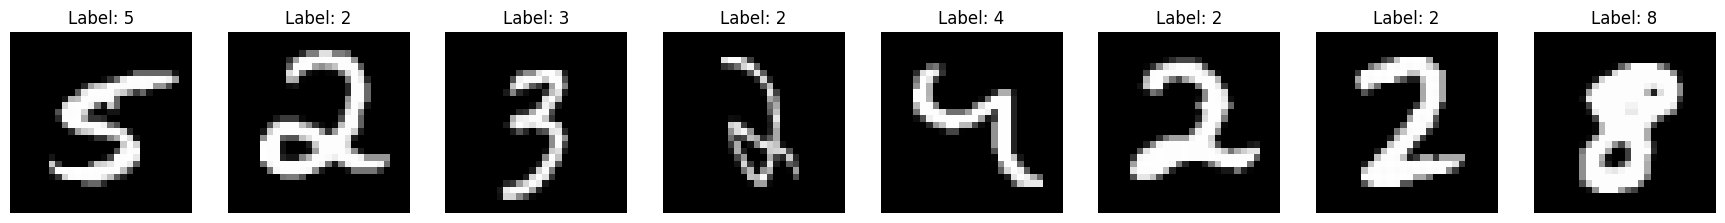

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(22,10))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

In [8]:
import torch.nn as nn

class VAE(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        #encoder block
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_dim),
            nn.ReLU()
        )

        #decoder block
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid() # apply the sigmoid activation function to compress the output to a range of (0, 1)
        )

        #Add mu and sigma
        self.mu = nn.Linear(hidden_dim, hidden_dim)
        # Neural nets can output any real value, but variance must be positive—so we predict log-variance instead.
        self.log_var = nn.Linear(hidden_dim, hidden_dim)

    def reparameterize(self, mu, log_var):
        #Compute std deviation from log_var: log_var = log(σ²) => σ = e^(log_var/2)
        std = torch.exp(log_var/2)
        # Generate random noise from standard normal distribution of the same shape as std
        eps = torch.randn_like(std) #generate random values matching the shape and device of an existing tensor
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        # Compute mean and log variance vectors
        # After the encoder, mu and log_var are computed in parallel from the same encoded vector using two separate linear layers.
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)

        #Reparametrize the latent variable
        z = self.reparameterize(mu, log_var)

        # Pass the latent variable through decoder
        decoded = self.decoder(z)
        return encoded, decoded, mu, log_var

In [9]:
import torch.nn.functional as F

#Define a loss function that combines binary cross-entropy and KL divergence: https://arxiv.org/pdf/1907.08956
def loss_function(x, decoded_x, mu, log_var):
    BCE = F.binary_cross_entropy(decoded_x, x, reduction="sum")
    #Compute KL divergence, this acts as regularization
    KL = -0.5 * torch.sum(1 + log_var - log_var.exp() - mu.pow(2))
    return BCE + KL

In [10]:
def train_model(train_loader, epochs = 100, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim, hidden_dim, output_dim = 784, 16, 784

    model = VAE(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0

        for batch_x, _ in train_loader:
            batch_x = batch_x.to(device) # Unlike model.to(device), batch_x.to(device) returns a new tensor (does NOT modify in place), so reassign: batch_x = batch_x.to(device)

            batch_x = batch_x.reshape(batch_x.shape[0], -1)

            #Forward pass
            encoded, decoded, mu, log_var = model(batch_x)
            loss = loss_function(batch_x, decoded, mu, log_var)
            optimizer.zero_grad()
            #Back prop
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_x.shape[0]

        epoch_loss = running_loss / len(train_loader.dataset)
        if epoch%10==0:
            print(f"Epoch {(epoch+1)}/{epochs} - Loss: {epoch_loss:.4f}")

    return model


In [12]:
trained_model = train_model(train_loader, epochs = 100)

Epoch 1/100 - Loss: 24522.5885
Epoch 11/100 - Loss: 14731.5615
Epoch 21/100 - Loss: 14215.9820
Epoch 31/100 - Loss: 14013.6758
Epoch 41/100 - Loss: 13906.4449
Epoch 51/100 - Loss: 13821.7280
Epoch 61/100 - Loss: 13761.7331
Epoch 71/100 - Loss: 13719.5745
Epoch 81/100 - Loss: 13679.8605
Epoch 91/100 - Loss: 13648.2215


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_x, _ = next(iter(test_loader))
batch_x = batch_x.to(device)

batch_x = batch_x.reshape(batch_x.shape[0], -1)

with torch.no_grad():
    encoded, decoded, mu, log_var = trained_model(batch_x[:10])

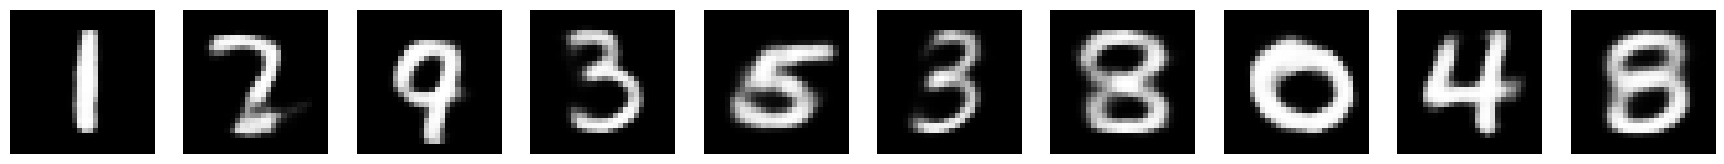

In [15]:
#Reconstructed images
plt.figure(figsize=(22,10))
i = 1
decoded_cpu = decoded.cpu()
for decoded_img in decoded_cpu:
    plt.subplot(1,10,i)
    plt.imshow(decoded_img.reshape(28,28), cmap='gray')
    plt.axis('off')

    i+=1
plt.show()

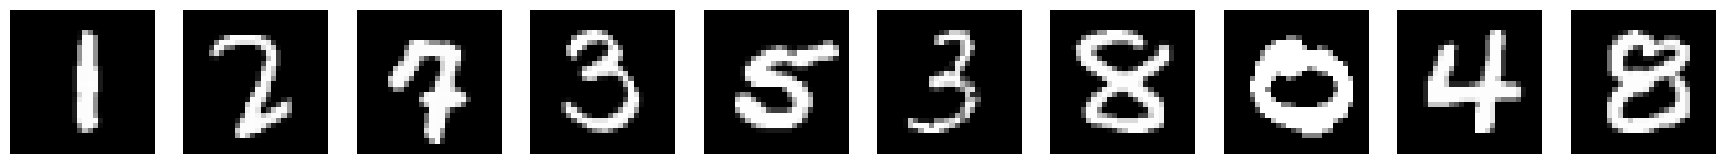

In [16]:
#True images
plt.figure(figsize=(22,10))
i = 1
true_image = batch_x[:10].cpu()
for img in true_image:
    plt.subplot(1,10,i)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')

    i+=1
plt.show()

In [26]:
#image generated from noise

def sample(num_samples):
    with torch.no_grad():
        #Generate Random noise
        hidden_dim = 16
        z = torch.randn(num_samples, hidden_dim).to(device)
        #Pass the generated noise through decoder
        decoded_imgs = trained_model.decoder(z)
    return decoded_imgs

In [27]:
decoded_imgs = sample(10)

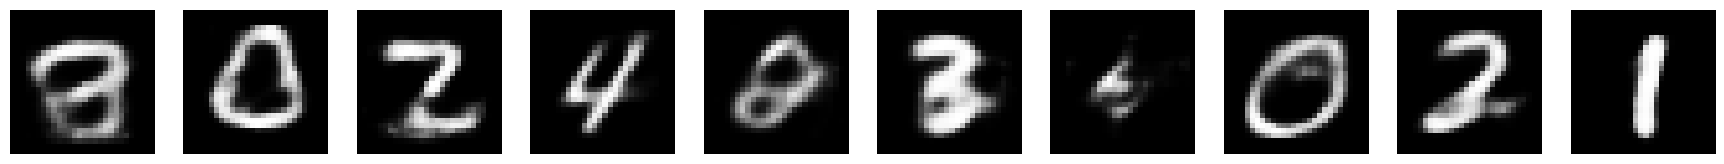

In [29]:
#image generated from noise
plt.figure(figsize=(22,10))
i = 1
for img in decoded_imgs.cpu():
    img = img.reshape(28, 28)
    plt.subplot(1,10,i)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')

    i+=1
plt.show()